In [215]:
import glob
import PIL
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Process BG Images

In [216]:
bg_images = [f for f in glob.glob('depth_dataset/bg/*.*')]

In [217]:
def crop_center(pil_img):
    img_width, img_height = pil_img.size
    crop_dim = img_width if img_width < img_height else img_height
    crop_width = crop_height = crop_dim
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

## Test on a Single Image

In [218]:
img = Image.open(bg_images[0])

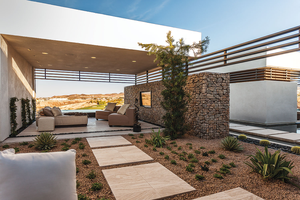

In [219]:
img.thumbnail((300, 300), Image.ANTIALIAS)
img

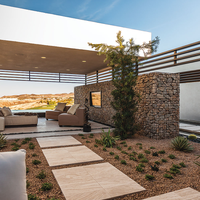

In [220]:
crop_center(img)

## Run on all the BG files

In [221]:
size = (200, 200)
for idx, bg_file in enumerate(bg_images):
    img = Image.open(bg_file)
    img = crop_center(img)
    img.thumbnail(size, Image.ANTIALIAS)
    img = img.convert('RGB')
    img.save(f'depth_dataset_cleaned/bg/bg_{idx:03d}.jpg', optimize=True, quality=60)

# Process FG Images

In [232]:
fg_images = [f for f in glob.glob('depth_dataset/fg/*.*')]

In [223]:
img = Image.open(fg_images[0])

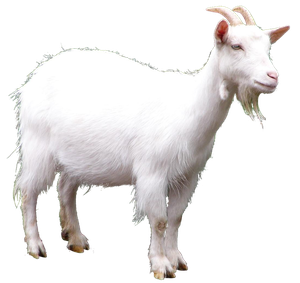

In [224]:
img.thumbnail((300, 300), Image.ANTIALIAS)
img

In [225]:
img = cv2.imread(fg_images[0], cv2.IMREAD_UNCHANGED)
ret, mask = cv2.threshold(im[:, :, 3], 0, 255, cv2.THRESH_BINARY)

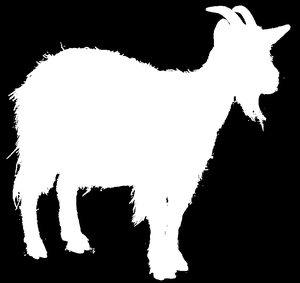

In [226]:
img = Image.fromarray(mask)
img.thumbnail((300, 300), Image.ANTIALIAS)
img

 We'll randomly resize our objects between a height of `80 to 110`, since the background is of `200x200` we dont want it to be bigger than half of the background, while also maintaining the aspect ratio

## Test on Single Image

101
(3609, 1523)
0.02798559157661402
(42, 101)


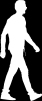

In [233]:
img = cv2.imread(fg_images[1], cv2.IMREAD_UNCHANGED)
_, mask = cv2.threshold(img[:, :, 3], 0, 255, cv2.THRESH_BINARY)

mask_height, mask_width = mask.shape

max_size = np.random.randint(low=80, high=110, size=1)[0]
print(max_size)

print(mask.shape)

if mask_width > mask_height:
    reduce_by = max_size / mask_width
else:
    reduce_by = max_size / mask_height

reduce_by
print(reduce_by)
       
height = int(mask_height * reduce_by)    
width = int(mask_width * reduce_by)

dsize = (width, height)

print(dsize)

resized = cv2.resize(mask, dsize, interpolation = cv2.INTER_AREA)
img = Image.fromarray(resized)
img = img.convert('L')
img

# Run on all FG Files

In [234]:
for idx, fg_file in enumerate(fg_images):
    # original image
    o_img = cv2.imread(fg_file, cv2.IMREAD_UNCHANGED)
    img = cv2.imread(fg_file, cv2.IMREAD_UNCHANGED)
    
    _, mask = cv2.threshold(img[:, :, 3], 0, 255, cv2.THRESH_BINARY)

    mask_height, mask_width = mask.shape

    max_size = np.random.randint(low=80, high=110, size=1)[0]

    if mask_width > mask_height:
        reduce_by = max_size / mask_width
    else:
        reduce_by = max_size / mask_height

    height = int(mask_height * reduce_by)    
    width = int(mask_width * reduce_by)

    dsize = (width, height)

    resized = cv2.resize(mask, dsize, interpolation = cv2.INTER_AREA)
    o_resized = cv2.resize(o_img, dsize, interpolation = cv2.INTER_AREA)
    
    img = Image.fromarray(resized)
    img = img.convert('L')
    img.save(f'depth_dataset_cleaned/fg_mask/fg_{idx:03d}.jpg', optimize=True, quality=30)
    
    o_resized = cv2.cvtColor(o_resized, cv2.COLOR_BGRA2RGBA)
    o_img = Image.fromarray(o_resized)
    o_img.save(f'depth_dataset_cleaned/fg/fg_{idx:03d}.png')

# Process FG_BG and Create Masks

In [265]:
fgc_images = [f for f in glob.glob('depth_dataset_cleaned/fg/*.*')]
bgc_images = [f for f in glob.glob('depth_dataset_cleaned/bg/*.*')]
fgc_mask_images = [f for f in glob.glob('depth_dataset_cleaned/fg_mask/*.*')]

In [266]:
fgc_images[0], bgc_images[0], fgc_mask_images[0]

('depth_dataset_cleaned/fg\\fg_000.png',
 'depth_dataset_cleaned/bg\\bg_000.jpg',
 'depth_dataset_cleaned/fg_mask\\fg_000.jpg')

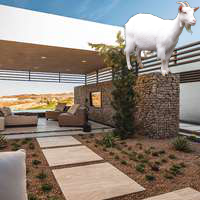

In [187]:
background = Image.open(bgc_images[0])
foreground = Image.open(fgc_images[0])

background.paste(foreground, (120, 0), foreground)
background

In [190]:
background.size, foreground.size

((200, 200), (82, 77))

In [242]:
background = Image.open(bgc_images[0])
foreground = Image.open(fgc_images[1])
b_width, b_height = background.size
f_width, f_height = foreground.size
max_y = b_height - f_height
max_x = b_width - f_width
pos_x = np.random.randint(low=0, high=max_x, size=1)[0]
pos_y = np.random.randint(low=0, high=max_y, size=1)[0]
background.paste(foreground, (pos_x, pos_y), foreground)
mask_bg = Image.new('L', background.size)
fg_mask = Image.open(fgc_mask_images[1])
fg_mask = fg_mask.convert('L')
mask_bg.paste(fg_mask, (pos_x, pos_y), fg_mask)

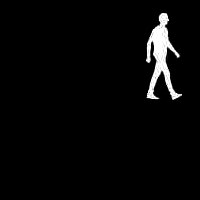

In [243]:
mask_bg

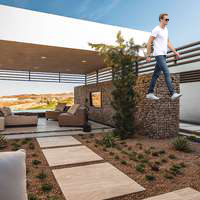

In [244]:
background

## this will dump all the files into a single folder

In [256]:
label_info = open("depth_dataset_cleaned/label_info.txt","w+")
idx = 0
for bidx, bg_image in enumerate(bgc_images):
    for fidx, fg_image in enumerate(fgc_images):
        # do the add fg to bg 20 times
        for i in range(20):
            # do this twice, one with flip once without
            for should_flip in [True, False]:
                background = Image.open(bg_image)
                foreground = Image.open(fg_image)
                fg_mask = Image.open(fgc_mask_images[fidx])
                
                if should_flip:
                    foreground = foreground.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                    fg_mask = fg_mask.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                    
                b_width, b_height = background.size
                f_width, f_height = foreground.size
                max_y = b_height - f_height
                max_x = b_width - f_width
                pos_x = np.random.randint(low=0, high=max_x, size=1)[0]
                pos_y = np.random.randint(low=0, high=max_y, size=1)[0]
                background.paste(foreground, (pos_x, pos_y), foreground)
                
                mask_bg = Image.new('L', background.size)

                fg_mask = fg_mask.convert('L')
                mask_bg.paste(fg_mask, (pos_x, pos_y), fg_mask)

                background.save(f'depth_dataset_cleaned/fg_bg/fg_{fidx:03d}_bg_{bidx:03d}_{idx:06d}.jpg', optimize=True, quality=30)
                mask_bg.save(f'depth_dataset_cleaned/fg_bg_mask/fg_{fidx:03d}_bg_{bidx:03d}_mask_{idx:06d}.jpg', optimize=True, quality=30)
                label_info.write(f'fg_{fidx:03d}_bg_{bidx:03d}_{idx:06d}.jpg\tfg_{fidx:03d}_bg_{bidx:03d}_mask_{idx:06d}.jpg\t{pos_x}\t{pos_y}\n')
                
                idx = idx + 1
label_info.close()

# this will create a separate folder for each background image

In [267]:
from pathlib import Path

In [269]:
label_info = open("depth_dataset_cleaned/label_info.txt","w+")
idx = 0
for bidx, bg_image in enumerate(bgc_images):
    Path(f'depth_dataset_cleaned/fg_bg/bg_{bidx:03d}').mkdir(parents=True, exist_ok=True)
    Path(f'depth_dataset_cleaned/fg_bg_mask/bg_{bidx:03d}').mkdir(parents=True, exist_ok=True)
    for fidx, fg_image in enumerate(fgc_images):
        # do the add fg to bg 20 times
        for i in range(20):
            # do this twice, one with flip once without
            for should_flip in [True, False]:
                background = Image.open(bg_image)
                foreground = Image.open(fg_image)
                fg_mask = Image.open(fgc_mask_images[fidx])
                
                if should_flip:
                    foreground = foreground.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                    fg_mask = fg_mask.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                    
                b_width, b_height = background.size
                f_width, f_height = foreground.size
                max_y = b_height - f_height
                max_x = b_width - f_width
                pos_x = np.random.randint(low=0, high=max_x, size=1)[0]
                pos_y = np.random.randint(low=0, high=max_y, size=1)[0]
                background.paste(foreground, (pos_x, pos_y), foreground)
                
                mask_bg = Image.new('L', background.size)

                fg_mask = fg_mask.convert('L')
                mask_bg.paste(fg_mask, (pos_x, pos_y), fg_mask)

                background.save(f'depth_dataset_cleaned/fg_bg/bg_{bidx:03d}/fg_{fidx:03d}_bg_{bidx:03d}_{idx:06d}.jpg', optimize=True, quality=30)
                mask_bg.save(f'depth_dataset_cleaned/fg_bg_mask/bg_{bidx:03d}/fg_{fidx:03d}_bg_{bidx:03d}_mask_{idx:06d}.jpg', optimize=True, quality=30)
                label_info.write(f'fg_bg/bg_{bidx:03d}/fg_{fidx:03d}_bg_{bidx:03d}_{idx:06d}.jpg\tfg_bg_mask/bg_{bidx:03d}/fg_{fidx:03d}_bg_{bidx:03d}_mask_{idx:06d}.jpg\t{pos_x}\t{pos_y}\n')
                
                idx = idx + 1
label_info.close()